In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np

label_col = 'survival_months'
n_bins = 4
eps = 1e-6

In [2]:
def add_bins(slide_data):
    assert 'case_id' in slide_data.columns and 'censorship' in slide_data.columns
    
    patients_df = slide_data.drop_duplicates(['case_id']).copy()
    uncensored_df = patients_df[patients_df['censorship'] < 1]
    disc_labels, q_bins = pd.qcut(uncensored_df[label_col], q=n_bins, retbins=True, labels=False)
    q_bins[-1] = slide_data[label_col].max() + eps
    q_bins[0] = slide_data[label_col].min() - eps

    disc_labels, q_bins = pd.cut(patients_df[label_col], bins=q_bins, retbins=True, labels=False, right=False, include_lowest=True)
    patients_df.insert(2, 'label', disc_labels.values.astype(int))

    patient_dict = {}
    slide_data = slide_data.set_index('case_id')
    for patient in patients_df['case_id']:
        slide_ids = slide_data.loc[patient, 'slide_id']
        if isinstance(slide_ids, str):
            slide_ids = np.array(slide_ids).reshape(-1)
        else:
            slide_ids = slide_ids.values
        patient_dict.update({patient:slide_ids})
        
    return q_bins, patient_dict, patients_df

In [3]:
slide_data = pd.read_csv('./tcga_gbmlgg_all_clean.csv.zip', compression='zip', header=0, index_col=0, sep=',',  low_memory=False)

n_bins = 4
eps = 1e-6

### Asserts that 'case_id' is a column, not an index.
if 'case_id' not in slide_data:
    slide_data.index = slide_data.index.str[:12]
    slide_data['case_id'] = slide_data.index
    slide_data = slide_data.reset_index(drop=True)

q_bins, patients_dict, slide_data = add_bins(slide_data)

slide_data.reset_index(drop=True, inplace=True)
slide_data = slide_data.assign(slide_id=slide_data['case_id'])

label_dict = {}
key_count = 0
for i in range(len(q_bins)-1):
    for c in [0, 1]:
        label_dict.update({(i, c):key_count})
        key_count+=1

for i in slide_data.index:
    key = slide_data.loc[i, 'label']
    slide_data.at[i, 'disc_label'] = key
    censorship = slide_data.loc[i, 'censorship']
    key = (key, int(censorship))
    slide_data.at[i, 'label'] = label_dict[key]

bins = q_bins
num_classes=len(label_dict)
patients_df = slide_data.drop_duplicates(['case_id'])
patient_data = {'case_id':patients_df['case_id'].values, 'label':patients_df['label'].values}

new_cols = list(slide_data.columns[-2:]) + list(slide_data.columns[:-2])
slide_data = slide_data[new_cols]
metadata = slide_data.columns[:11]

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def series_intersection(s1, s2):
    return pd.Series(list(set(s1) & set(s2)))

genomic_features = slide_data.drop(metadata, axis=1)
scaler_omic = StandardScaler().fit(genomic_features)

In [9]:
import os
from os.path import join

import pandas as pd
import numpy as np

signatures = pd.read_csv('./signatures.csv')
slide_df = pd.read_csv('./tcga_gbmlgg_all_clean.csv.zip')

/home/mahmoodlab/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [43]:
pd.read_csv(fname)

,Unnamed: 0,Unnamed: 0.1,case_id,slide_id,site,is_female,oncotree_code,age,survival_months,censorship,...,ZSCAN10_rnaseq,ZSCAN12_rnaseq,ZSCAN20_rnaseq,ZSCAN21_rnaseq,ZSCAN22_rnaseq,ZSCAN2_rnaseq,ZSCAN9_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq
0,0,0,TCGA-02-0047,TCGA-02-0047-01Z-00-DX1.4755D138-5842-4159-848...,2,0.0,GBM,78.0,14.72,0.0,...,-0.1599,-0.59540,0.0813,-1.16960,-0.1728,-0.1144,-0.4155,0.4046,-0.01680,0.3026
1,1,1,TCGA-06-0125,TCGA-06-0125-01Z-00-DX1.8e0915b2-8dc3-4753-806...,6,1.0,GBM,63.0,47.57,0.0,...,0.4608,0.52815,1.2580,1.41685,2.4839,-0.2388,0.9025,0.3242,1.01905,0.2265
2,2,2,TCGA-06-0125,TCGA-06-0125-01Z-00-DX2.4f9cef92-2bdb-480d-870...,6,1.0,GBM,63.0,47.57,0.0,...,0.4608,0.52815,1.2580,1.41685,2.4839,-0.2388,0.9025,0.3242,1.01905,0.2265
3,3,3,TCGA-06-0129,TCGA-06-0129-01Z-00-DX1.b7bddf7d-f39e-45e7-a78...,6,0.0,GBM,30.0,33.64,0.0,...,-0.2960,-0.75980,1.2706,-0.14840,1.4803,1.5796,1.0245,1.0492,5.78560,1.7766
4,4,4,TCGA-06-0129,TCGA-06-0129-01Z-00-DX2.1ea78b46-1dc7-44d8-81b...,6,0.0,GBM,30.0,33.64,0.0,...,-0.2960,-0.75980,1.2706,-0.14840,1.4803,1.5796,1.0245,1.0492,5.78560,1.7766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,1037,1037,TCGA-WY-A85A,TCGA-WY-A85A-01Z-00-DX1.CB302B89-F89A-40FD-A7D...,WY,0.0,ASTR,20.0,43.36,1.0,...,-0.2997,-0.67560,0.2714,0.36210,-0.2401,1.4333,0.2715,-0.5415,-0.69620,-0.1123
1038,1038,1038,TCGA-WY-A85B,TCGA-WY-A85B-01Z-00-DX1.1E4B796A-A1E3-45F9-807...,WY,0.0,ASTR,24.0,45.76,1.0,...,-0.0678,0.30360,0.3361,1.21610,0.9365,1.4954,1.4201,-0.3525,0.52860,0.1971
1039,1039,1039,TCGA-WY-A85C,TCGA-WY-A85C-01Z-00-DX1.E0A6429A-91B3-4FFE-9FF...,WY,0.0,ASTR,36.0,46.85,1.0,...,0.0320,-1.01940,0.6582,2.55740,1.4708,0.8381,2.9481,0.1252,0.75300,0.9603
1040,1040,1040,TCGA-WY-A85D,TCGA-WY-A85D-01Z-00-DX1.FB8C252B-7A88-4B14-B3C...,WY,0.0,OAST,60.0,37.68,1.0,...,-0.3021,-0.34820,-0.4824,1.57910,0.0187,-0.7983,1.4101,-1.0976,-1.00950,0.5940


In [76]:
omic_from_signatures = []
for col in signatures.columns:
    omic = signatures[col].dropna().unique()
    omic_from_signatures.append(omic)

omic_from_signatures = np.concatenate(omic_from_signatures)

In [44]:
for fname in os.listdir('./'):
    if fname.endswith('.csv.zip'):
        slide_df = pd.read_csv(fname)

/home/mahmoodlab/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [81]:
fname = '../dataset_csv/tcga_luad_all_clean.csv.zip'
slide_df = pd.read_csv(fname)
slide_df

,Unnamed: 0,Unnamed: 0.1,case_id,slide_id,site,is_female,oncotree_code,age,survival_months,censorship,...,ZSCAN10_rnaseq,ZSCAN12_rnaseq,ZSCAN20_rnaseq,ZSCAN21_rnaseq,ZSCAN22_rnaseq,ZSCAN2_rnaseq,ZSCAN9_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq
0,0,0,TCGA-05-4249,TCGA-05-4249-01Z-00-DX1.9fce0297-cc19-4c04-872...,5,0.0,LUAD,67.0,50.03,1.0,...,-0.1238,0.7530,0.6552,-1.0013,0.2353,2.6532,1.1103,0.6149,0.5725,0.2889
1,1,1,TCGA-05-4250,TCGA-05-4250-01Z-00-DX1.90f67fdf-dff9-46ca-af7...,5,1.0,LUAD,79.0,3.98,0.0,...,-0.1238,0.4810,-0.8255,0.2825,-1.2502,-0.9024,-0.1472,0.5118,-0.1673,-0.8006
2,2,2,TCGA-05-4382,TCGA-05-4382-01Z-00-DX1.76b49a4c-dbbb-48b0-b67...,5,0.0,LUAD,68.0,19.94,1.0,...,0.3265,0.4462,1.1847,0.8765,-0.7999,1.7566,1.1757,-0.4399,-0.2751,-0.4668
3,3,3,TCGA-05-4384,TCGA-05-4384-01Z-00-DX1.CA68BF29-BBE3-4C8E-B48...,5,0.0,LUAD,66.0,13.99,1.0,...,-0.1238,-0.0369,0.5766,0.0083,0.1344,0.8299,0.6599,1.4844,0.9748,0.7481
4,4,4,TCGA-05-4390,TCGA-05-4390-01Z-00-DX1.858E64DF-DD3E-4F43-B7C...,5,1.0,LUAD,58.0,36.99,1.0,...,-0.1238,0.4751,1.2404,0.6932,-0.2792,2.1326,0.1621,-0.0462,1.8418,-0.9922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,511,511,TCGA-NJ-A55O,TCGA-NJ-A55O-01Z-00-DX1.8E23C821-B8BB-4D89-9E3...,NJ,1.0,LUAD,56.0,0.43,1.0,...,-0.0781,-0.2368,0.5056,-0.2771,0.1067,-0.0153,-0.2546,-0.4205,-0.3773,0.0551
512,512,512,TCGA-NJ-A55R,TCGA-NJ-A55R-01Z-00-DX1.2E2B3642-4E1C-47DB-AF7...,NJ,0.0,LUAD,67.0,19.81,1.0,...,6.1880,0.2405,0.0751,1.9723,0.6093,0.6135,1.7846,0.0588,-0.1157,1.2831
513,513,513,TCGA-NJ-A7XG,TCGA-NJ-A7XG-01Z-00-DX1.4A876254-653C-410B-A36...,NJ,0.0,LUAD,49.0,20.27,1.0,...,-0.1238,-0.0041,-0.8129,-0.4409,0.6778,-0.5506,1.4350,-1.5823,-1.3015,0.4371
514,514,514,TCGA-O1-A52J,TCGA-O1-A52J-01Z-00-DX1.26F6ECCA-D614-4950-98E...,O1,1.0,LUAD,74.0,59.07,0.0,...,-0.1238,-0.1263,0.8472,-0.3943,-0.7671,-1.1313,-0.9671,4.2234,0.9716,0.6699


In [79]:
fname = '../dataset_csv/tcga_luad_all_clean.csv.zip'
slide_df = pd.read_csv(fname)
omic_overlap = np.concatenate([omic_from_signatures+mode for mode in ['_mut', '_cnv', '_rnaseq']])
omic_overlap = sorted(series_intersection(omic_overlap, slide_df.columns))
slide_df[list(slide_df.columns[:9]) + omic_overlap].to_csv('../dataset_csv_sig/%s' % fname)

In [54]:
for fname in os.listdir('./'):
    if fname.endswith('.csv.zip'):
        slide_df = pd.read_csv(fname)

/home/mahmoodlab/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
fname

'tcga_luad_all_clean.csv.zip'

In [15]:


omic_from_signatures = []
for col in signatures.columns:
    omic = signatures[col].dropna().unique()
    omic_from_signatures.append(omic)

omic_from_signatures = np.concatenate(omic_from_signatures)

def series_intersection(s1, s2):
    return pd.Series(list(set(s1) & set(s2)))

signatures = pd.read_csv('./signatures.csv')
slide_df = pd.read_csv('./tcga_gbmlgg_all_clean.csv.zip')
rnaseq_overlap = np.concatenate([omic_from_signatures+mode for mode in ['_rnaseq']])
rnaseq_overlap = sorted(series_intersection(rnaseq_overlap, slide_df.columns))
genomics_mut_cnv = list(slide_df.columns[slide_df.columns.str.contains('_mut|_cnv')])

/home/mahmoodlab/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
_ = slide_df[list(slide_df.columns[:9]) + rnaseq_overlap + genomics_mut_cnv]

In [17]:
_

,case_id,slide_id,site,is_female,oncotree_code,age,survival_months,censorship,train,AAK1_rnaseq,...,AGAP2_cnv,TSPAN31_cnv,CDK4_cnv,MARCH9_cnv,CYP27B1_cnv,METTL1_cnv,TSFM_cnv,AVIL_cnv,CTDSP2_cnv,RN7SKP65_cnv
0,TCGA-02-0047,TCGA-02-0047-01Z-00-DX1.4755D138-5842-4159-848...,2,0.0,GBM,78.0,14.72,0.0,1.0,1.5517,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-06-0125,TCGA-06-0125-01Z-00-DX1.8e0915b2-8dc3-4753-806...,6,1.0,GBM,63.0,47.57,0.0,1.0,0.5557,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-06-0125,TCGA-06-0125-01Z-00-DX2.4f9cef92-2bdb-480d-870...,6,1.0,GBM,63.0,47.57,0.0,1.0,0.5557,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-06-0129,TCGA-06-0129-01Z-00-DX1.b7bddf7d-f39e-45e7-a78...,6,0.0,GBM,30.0,33.64,0.0,1.0,0.6442,...,2,2,2,2,2,2,2,2,2,2
4,TCGA-06-0129,TCGA-06-0129-01Z-00-DX2.1ea78b46-1dc7-44d8-81b...,6,0.0,GBM,30.0,33.64,0.0,1.0,0.6442,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,TCGA-WY-A85A,TCGA-WY-A85A-01Z-00-DX1.CB302B89-F89A-40FD-A7D...,WY,0.0,ASTR,20.0,43.36,1.0,1.0,-0.3841,...,0,0,0,0,0,0,0,0,0,0
1038,TCGA-WY-A85B,TCGA-WY-A85B-01Z-00-DX1.1E4B796A-A1E3-45F9-807...,WY,0.0,ASTR,24.0,45.76,1.0,1.0,-0.4479,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1039,TCGA-WY-A85C,TCGA-WY-A85C-01Z-00-DX1.E0A6429A-91B3-4FFE-9FF...,WY,0.0,ASTR,36.0,46.85,1.0,1.0,-0.2472,...,0,0,0,0,0,0,0,0,0,0
1040,TCGA-WY-A85D,TCGA-WY-A85D-01Z-00-DX1.FB8C252B-7A88-4B14-B3C...,WY,0.0,OAST,60.0,37.68,1.0,1.0,-0.5892,...,0,0,0,0,0,0,0,0,0,0


In [30]:
from scipy import stats

slide_df = pd.read_csv(fname)
rnaseq = slide_df[slide_df.columns[slide_df.columns.str.contains('_rnaseq')]]

top_k=2000
mad = stats.median_abs_deviation(rnaseq, axis=0)
sort_idx = np.argsort(mad)[-top_k:]
rnaseq = rnaseq[rnaseq.columns[sort_idx]]

In [45]:
rnaseq

,CLASRP_rnaseq,NBAS_rnaseq,ARL2BP_rnaseq,TMEM199_rnaseq,TTC37_rnaseq,GTF2I_rnaseq,STYX_rnaseq,TSR3_rnaseq,SEC61A1_rnaseq,TRRAP_rnaseq,...,GET4_rnaseq,BRD9_rnaseq,NSUN2_rnaseq,PYCRL_rnaseq,HGH1_rnaseq,PRUNE_rnaseq,MAF1_rnaseq,CCDC127_rnaseq,EXOC3_rnaseq,PUF60_rnaseq
0,-0.5874,0.8371,0.7587,0.2188,-0.4040,2.3916,-0.7124,-1.0035,0.7356,-0.0249,...,-0.1915,0.3503,-1.1848,-1.4121,-0.2389,5.0110,1.4287,-0.3531,-0.8503,1.2995
1,0.2811,0.2232,0.9000,3.2327,-0.0096,-0.4464,0.5219,0.3927,-0.3513,-0.7917,...,0.7627,-0.6092,0.1291,1.7400,-0.0250,-0.1531,0.5344,-0.0012,-0.9606,2.0233
2,1.5665,-0.4726,0.1693,0.9845,-0.6740,-0.3986,-0.2289,-0.2791,-0.0646,-0.4431,...,4.4123,1.4417,-0.5196,-1.3030,-1.1373,4.6041,-1.0135,1.3589,2.6994,-0.3068
3,0.6169,-0.3266,-0.3082,-0.2220,0.5305,0.5360,0.2785,-1.0873,-1.0712,-0.3184,...,0.7665,-0.3344,0.0695,0.0040,0.2291,3.6034,0.1774,-0.2766,0.5080,0.6178
4,0.6406,-1.0330,-0.6522,0.1727,-0.7455,-0.6040,0.2553,1.0504,1.0583,-0.2884,...,3.3807,0.3364,-0.2792,4.8566,7.9296,1.6951,5.8943,1.3652,-0.8062,9.2417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.5640,0.1255,-1.3364,-0.8430,0.4406,-0.9735,-1.4547,-0.1983,-0.5259,-0.2029,...,3.0311,3.4963,2.5079,0.0556,0.5691,0.1104,-0.3776,2.6136,3.4259,-0.8442
512,1.2336,0.1902,-1.3500,-0.3472,0.4549,-0.6806,-1.1291,1.0677,1.1586,0.1959,...,0.5573,-0.7546,0.8104,0.1239,0.0985,2.9026,0.0173,0.3492,2.5703,1.0690
513,1.8148,-0.8502,-0.0628,-0.7776,0.6452,-0.4622,-1.2732,1.8145,-0.8767,-0.2980,...,1.4671,2.2343,2.1466,0.7868,0.6893,0.1571,0.9686,3.0870,5.6169,0.5300
514,0.0569,-0.4511,3.8784,0.2609,0.9393,0.5776,-0.9469,2.9500,-0.9261,2.4218,...,5.0440,0.0862,0.1431,-0.7761,-0.8430,0.2311,-0.5913,1.4958,2.1736,-0.5699


In [51]:
import torch

ModuleNotFoundError: No module named 'torch'

In [20]:
slide_df[slide_df.columns.str.contains('_rnaseq')]

Index(['UBE2Q2P2_rnaseq', 'SSX9_rnaseq', 'CXORF67_rnaseq', 'EFCAB8_rnaseq',
       'SDR16C6P_rnaseq', 'EFCAB12_rnaseq', 'A1BG_rnaseq', 'A1CF_rnaseq',
       'RBFOX1_rnaseq', 'GGACT_rnaseq',
       ...
       'ZWINT_rnaseq', 'ZXDA_rnaseq', 'ZXDB_rnaseq', 'ZXDC_rnaseq',
       'ZYG11A_rnaseq', 'ZYG11B_rnaseq', 'ZYX_rnaseq', 'ZZEF1_rnaseq',
       'ZZZ3_rnaseq', 'TPTEP1_rnaseq'],
      dtype='object', length=18345)

In [24]:
slide_df = pd.read_csv(fname)
slide_df = slide_df[slide_df.columns[slide_df.columns.str.contains('_rnaseq')]]

In [25]:
slide_df

,UBE2Q2P2_rnaseq,SSX9_rnaseq,CXORF67_rnaseq,EFCAB8_rnaseq,SDR16C6P_rnaseq,EFCAB12_rnaseq,A1BG_rnaseq,A1CF_rnaseq,RBFOX1_rnaseq,GGACT_rnaseq,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
0,-0.3291,-0.1379,-0.1805,-0.0869,-0.3317,-0.1661,-0.1483,-0.1371,-0.2260,-0.5346,...,-0.7082,0.6149,0.5725,0.2889,-0.5255,-0.2205,-0.7847,-0.2296,-0.0897,0.1457
1,-0.8531,-0.1379,-0.1805,-0.2629,-0.3317,-0.2317,-0.5528,-0.1476,-0.2508,0.6921,...,0.9291,0.5118,-0.1673,-0.8006,-0.4348,-1.7113,0.7466,-0.1563,-0.9102,-0.5005
2,-0.7262,0.3883,0.4908,-0.0666,-0.3317,-0.3948,0.0021,-0.1476,-0.2508,-0.0800,...,0.2957,-0.4399,-0.2751,-0.4668,0.1222,0.3555,1.4078,-0.1592,-0.2276,-0.3931
3,-1.0590,-0.1379,-0.1805,-0.0959,-0.3317,-0.3372,-0.1061,-0.1476,-0.2508,-0.5641,...,-0.9962,1.4844,0.9748,0.7481,-0.7049,-0.2617,-0.2934,1.1243,0.0823,0.8831
4,-0.7257,-0.1379,-0.1805,-0.1756,-0.3317,-0.3778,0.1119,-0.1476,1.2515,-1.0113,...,1.7870,-0.0462,1.8418,-0.9922,-0.7090,-1.0285,0.6567,-1.0377,-1.1277,-0.5026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,0.5308,-0.1379,-0.1805,-0.2629,-0.3317,-0.2827,-0.6045,-0.1476,-0.2508,-0.2014,...,-0.5331,-0.4205,-0.3773,0.0551,-0.5660,-0.5123,0.1254,0.2124,-0.6375,1.4712
512,-0.5021,-0.1379,-0.0120,1.7408,-0.3317,-0.2152,0.7495,1.8708,-0.1178,-1.3502,...,-0.3624,0.0588,-0.1157,1.2831,-0.0555,-0.3620,-0.4242,1.6937,-0.4990,2.2944
513,5.2714,-0.1379,-0.1805,0.1753,-0.3317,-0.2325,0.5863,-0.1476,-0.0185,-0.3172,...,-0.9598,-1.5823,-1.3015,0.4371,-0.6739,-1.4417,-0.9613,0.4167,-1.4631,-0.5035
514,0.6290,-0.1379,0.1131,-0.0667,1.5316,-0.3634,0.3730,-0.1476,-0.2361,-1.7106,...,-0.5337,4.2234,0.9716,0.6699,-0.8134,-0.2453,0.2731,0.6346,-1.1963,0.1686


In [18]:
### Snippet for creating genomic signatures
for fname in os.listdir('./'):
    if fname.endswith('.csv.zip'):
        slide_df = pd.read_csv(fname)
        
        signatures = pd.read_csv('./signatures.csv')
        omic_from_signatures = []
        for col in signatures.columns:
            omic = signatures[col].dropna().unique()
            omic_from_signatures.append(omic)

        omic_from_signatures = np.concatenate(omic_from_signatures)

        def series_intersection(s1, s2):
            return pd.Series(list(set(s1) & set(s2)))

        rnaseq_overlap = np.concatenate([omic_from_signatures+mode for mode in ['_rnaseq']])
        rnaseq_overlap = sorted(series_intersection(rnaseq_overlap, slide_df.columns))
        genomics_mut_cnv = list(slide_df.columns[slide_df.columns.str.contains('_mut|_cnv')])
        
        slide_df[list(slide_df.columns[:9]) + rnaseq_overlap + genomics_mut_cnv].to_csv('../dataset_csv_mutsigdb/%s' % fname)

<ipython-input-18-1ae2fdcf544f>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(list(set(s1) & set(s2)))
/home/mahmoodlab/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/mahmoodlab/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [36]:
omic_from_signatures = []
for col in signatures.columns:
    omic = signatures[col].dropna().unique()
    omic_from_signatures.append(omic)

omic_from_signatures = np.concatenate(omic_from_signatures)


In [7]:

def series_intersection(s1, s2):
    return pd.Series(list(set(s1) & set(s2)))

sig_names = []
for col in signatures.columns:
    sig = signatures[col].dropna().unique()
    sig = np.concatenate([sig+mode for mode in ['_mut', '_cnv', '_rnaseq']])
    sig = sorted(series_intersection(sig, genomic_features.columns))
    sig_names.append(sig)
    print('%s Embedding Size: %d' % (col, len(sig)))
sig_sizes = [len(sig) for sig in sig_names]

Tumor Suppressor Genes Embedding Size: 84
Oncogenes Embedding Size: 314
Protein Kinases Embedding Size: 498
Cell Differentiation Markers Embedding Size: 415
Transcription Factors Embedding Size: 1396
Cytokines and Growth Factors Embedding Size: 428


In [21]:
sig

['IFNA10_cnv',
 'IFNA13_cnv',
 'IFNA14_cnv',
 'IFNA16_cnv',
 'IFNA17_cnv',
 'IFNA1_cnv',
 'IFNA21_cnv',
 'IFNA2_cnv',
 'IFNA4_cnv',
 'IFNA5_cnv',
 'IFNA6_cnv',
 'IFNA7_cnv',
 'IFNA8_cnv',
 'IFNB1_cnv',
 'IFNE_cnv',
 'IFNW1_cnv',
 'PDGFRA_cnv']

In [434]:
genomic_features

,NDUFS5_cnv,MACF1_cnv,RNA5SP44_cnv,KIAA0754_cnv,BMP8A_cnv,PABPC4_cnv,SNORA55_cnv,HEYL_cnv,HPCAL4_cnv,NT5C1A_cnv,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-0.8388,4.1375,3.9664,1.8437,-0.3959,-0.2561,-0.2866,1.8770,-0.3179,-0.3633
1,2,2,2,2,2,2,2,2,2,2,...,-0.1083,0.3393,0.2769,1.7320,-0.0975,2.6955,-0.6741,1.0323,1.2766,-0.3982
2,0,0,0,0,0,0,0,0,0,0,...,-0.4155,1.6846,0.7711,-0.3061,-0.5016,2.8548,-0.6171,-0.8608,-0.0486,-0.3962
3,0,0,0,0,0,0,0,0,0,0,...,-0.8143,0.8344,1.5075,3.6068,-0.5004,-0.0747,-0.2185,-0.4379,1.6913,1.7748
4,0,0,0,0,0,0,0,0,0,0,...,0.0983,-0.7908,-0.0053,-0.0643,-0.3706,0.3870,-0.5589,-0.5979,0.0047,-0.3548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2,2,2,2,2,2,2,2,2,2,...,-0.0291,-0.1058,-0.6721,0.2802,1.9504,-0.8784,0.9506,0.0607,1.1883,-0.3521
369,0,0,0,0,0,0,0,0,0,0,...,0.0497,0.3673,-0.2208,0.3034,3.2580,-0.2089,1.6053,-0.8746,-0.4491,-0.3450
370,1,1,1,1,1,1,1,1,1,1,...,0.3822,-0.7003,-0.7661,-1.7035,-0.5423,-0.3488,1.3713,-0.4365,2.3456,-0.3866
371,0,0,0,0,0,0,0,0,0,0,...,-0.6853,-1.0240,-1.2890,-1.5666,-0.1270,-1.4662,0.3981,-0.5976,-1.3822,-0.4157


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
import numpy as np

class MIL_Sum_FC_surv(nn.Module):
    def __init__(self, size_arg = "small", dropout=0.25, n_classes=4):
        super(MIL_Sum_FC_surv, self).__init__()

        self.size_dict = {"small": [1024, 512, 256], "big": [1024, 512, 384]}
        size = self.size_dict[size_arg]
        self.phi = nn.Sequential(*[nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)])
        self.rho = nn.Sequential(*[nn.Linear(size[1], size[2]), nn.ReLU(), nn.Dropout(dropout)])
        self.classifier = nn.Linear(size[2], n_classes)

    def relocate(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.device_count() >= 1:
            device_ids = list(range(torch.cuda.device_count()))
            self.phi = nn.DataParallel(self.phi, device_ids=device_ids).to('cuda:0')

        self.rho = self.rho.to(device)
        self.classifier = self.classifier.to(device)

    def forward(self, **kwargs):
        h = kwargs['x_path']

        h = self.phi(h).sum(axis=0)
        h = self.rho(h)
        logits  = self.classifier(h).unsqueeze(0)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        hazards = torch.sigmoid(logits)
        S = torch.cumprod(1 - hazards, dim=1)
        
        return hazards, S, Y_hat, None, None

from os.path import join
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
import numpy as np

"""
A Modified Implementation of Deep Attention MIL
"""


"""
Attention Network without Gating (2 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes (experimental usage for multiclass MIL)
"""
class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

"""
Attention Network with Sigmoid Gating (3 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes (experimental usage for multiclass MIL)
"""
class Attn_Net_Gated(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x
    
class MIL_Cluster_FC_surv(nn.Module):
    def __init__(self, num_clusters=10, size_arg = "small", dropout=0.25, n_classes=4):
        super(MIL_Cluster_FC_surv, self).__init__()
        self.size_dict = {"small": [1024, 512, 256], "big": [1024, 512, 384]}
        self.num_clusters = num_clusters
        
        ### Phenotype Learning
        size = self.size_dict[size_arg]
        phis = []
        for phenotype_i in range(num_clusters):
            phi = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout),
                   nn.Linear(size[1], size[1]), nn.ReLU(), nn.Dropout(dropout)]
            phis.append(nn.Sequential(*phi))
        self.phis = nn.ModuleList(phis)
        self.pool1d = nn.AdaptiveAvgPool1d(1)
        
        
        ### WSI Attention MIL Construction
        fc = [nn.Linear(size[1], size[1]), nn.ReLU()]
        fc.append(nn.Dropout(0.25))
        attention_net = Attn_Net_Gated(L=size[1], D=size[2], dropout=dropout, n_classes=1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)

        
        self.rho = nn.Sequential(*[nn.Linear(size[1], size[2]), nn.ReLU(), nn.Dropout(dropout)])
        self.classifier = nn.Linear(size[2], n_classes)

    def relocate(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.device_count() >= 1:
            device_ids = list(range(torch.cuda.device_count()))
            self.phis = nn.DataParallel(self.phi, device_ids=device_ids).to('cuda:0')

        self.rho = self.rho.to(device)
        self.classifier = self.classifier.to(device)

    def forward(self, **kwargs):
        x_path = kwargs['x_path']
        ### Phenotyping
        h_phenotypes = []
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=2021).fit(X)
        #cluster_ids_x, cluster_centers = kmeans(X=x_path, num_clusters=self.num_clusters, distance='euclidean', device=torch.device('cpu'))
        cluster_ids_x = KMeans(n_clusters=10, random_state=2021, max_iter=20).fit_predict(x_path)
        for i in range(self.num_clusters):
            h_phenotypes_i = self.phis[i](x_path[cluster_ids_x==i])
            h_phenotypes.append(self.pool1d(h_phenotypes_i.T.unsqueeze(0)).squeeze(2))
        h_phenotypes = torch.stack(h_phenotypes, dim=1).squeeze(0)


        ### Attention MIL
        A, h = self.attention_net(h_phenotypes)  
        A = torch.transpose(A, 1, 0)
        if 'attention_only' in kwargs.keys():
            if kwargs['attention_only']:
                return A
        A_raw = A 
        A = F.softmax(A, dim=1) 
        h = torch.mm(A, h_phenotypes)

        
        h = self.rho(h)
        logits  = self.classifier(h).unsqueeze(0)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        hazards = torch.sigmoid(logits)
        S = torch.cumprod(1 - hazards, dim=1)
        
        return hazards, S, Y_hat, None, None

In [15]:
x_path = torch.randint(10, size=(500, 1024)).type(torch.cuda.FloatTensor)


In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=2021, max_iter=20).fit_predict(x_path.cpu())

In [18]:
kmeans

array([5, 5, 3, 5, 8, 4, 8, 7, 5, 4, 9, 1, 9, 1, 6, 1, 1, 0, 5, 0, 4, 3,
       0, 6, 3, 1, 0, 7, 9, 8, 0, 5, 5, 3, 0, 1, 5, 1, 0, 6, 6, 4, 1, 5,
       3, 0, 1, 0, 8, 5, 1, 8, 1, 0, 5, 0, 2, 5, 6, 5, 0, 0, 5, 1, 2, 7,
       4, 6, 5, 3, 0, 7, 9, 1, 3, 4, 4, 5, 7, 9, 9, 5, 0, 1, 9, 1, 2, 0,
       6, 3, 1, 1, 2, 4, 0, 5, 1, 1, 1, 0, 0, 9, 8, 1, 5, 5, 0, 9, 2, 3,
       7, 0, 1, 6, 7, 5, 3, 5, 0, 1, 6, 1, 6, 2, 8, 7, 6, 1, 6, 2, 5, 0,
       1, 6, 0, 9, 2, 1, 0, 1, 7, 7, 6, 1, 6, 0, 3, 4, 1, 3, 2, 4, 4, 5,
       4, 1, 1, 9, 6, 0, 3, 6, 4, 8, 7, 9, 6, 5, 5, 9, 0, 6, 0, 1, 9, 2,
       3, 5, 1, 9, 6, 1, 0, 6, 6, 0, 0, 6, 7, 1, 6, 1, 1, 1, 4, 0, 2, 1,
       9, 5, 7, 5, 9, 0, 1, 0, 6, 2, 2, 1, 1, 5, 3, 5, 3, 6, 5, 6, 9, 5,
       2, 2, 2, 6, 0, 0, 0, 5, 2, 6, 6, 0, 2, 5, 1, 9, 2, 4, 4, 0, 4, 7,
       4, 1, 1, 3, 6, 0, 1, 2, 4, 0, 8, 1, 8, 5, 5, 7, 4, 1, 6, 1, 0, 8,
       6, 1, 1, 4, 8, 7, 5, 2, 3, 0, 2, 9, 5, 6, 4, 3, 6, 5, 5, 4, 6, 6,
       0, 1, 5, 1, 1, 1, 1, 9, 5, 7, 3, 0, 2, 4, 0,

In [2]:
x_path = torch.randint(10, size=(500, 1024)).type(torch.FloatTensor)
model = MIL_Sum_FC_surv()
model.forward(x_path=x_path)

(tensor([[0.9992, 0.0000, 0.0000, 1.0000]], grad_fn=<SigmoidBackward>),
 tensor([[0.0008, 0.0008, 0.0008, 0.0000]], grad_fn=<CumprodBackward>),
 tensor([[3]]),
 None,
 None)

In [3]:
x_path = torch.randint(10, size=(500, 1024)).type(torch.FloatTensor)
self = MIL_Cluster_FC_surv()
model.forward(x_path=x_path)

(tensor([[4.2595e-07, 1.0000e+00, 0.0000e+00, 7.2488e-12]],
        grad_fn=<SigmoidBackward>),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000]], grad_fn=<CumprodBackward>),
 tensor([[1]]),
 None,
 None)

In [7]:
import os
fname = os.path.join('/media/ssd1/pan-cancer/tcga_gbm_20x_features/h5_files/TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47.h5')

In [27]:
import h5py
h5 = h5py.File(fname, "r")
coords = np.array(h5['coords'])

In [ ]:
fm

In [17]:
np.array(h5['coords'])[0]

array([43121, 29428])

In [19]:
np.array(h5['coords'])[1]

array([43121, 29940])

In [20]:
np.array(h5['coords'])[1][1] - np.array(h5['coords'])[0][1]

512

In [21]:
np.array(h5['coords'])[2][1] - np.array(h5['coords'])[1][1]

512

In [23]:
import nmslib
class Hnsw:

    def __init__(self, space='cosinesimil', index_params=None,
                 query_params=None, print_progress=True):
        self.space = space
        self.index_params = index_params
        self.query_params = query_params
        self.print_progress = print_progress

    def fit(self, X):
        index_params = self.index_params
        if index_params is None:
            index_params = {'M': 16, 'post': 0, 'efConstruction': 400}

        query_params = self.query_params
        if query_params is None:
            query_params = {'ef': 90}

        # this is the actual nmslib part, hopefully the syntax should
        # be pretty readable, the documentation also has a more verbiage
        # introduction: https://nmslib.github.io/nmslib/quickstart.html
        index = nmslib.init(space=self.space, method='hnsw')
        index.addDataPointBatch(X)
        index.createIndex(index_params, print_progress=self.print_progress)
        index.setQueryTimeParams(query_params)

        self.index_ = index
        self.index_params_ = index_params
        self.query_params_ = query_params
        return self

    def query(self, vector, topn):
        # the knnQuery returns indices and corresponding distance
        # we will throw the distance away for now
        indices, _ = self.index_.knnQuery(vector, k=topn)
        return indices

In [ ]:
x

In [54]:
model = Hnsw(space='l2')
model.fit(coords)
model.query(coords, topn=8)

array([85, 87, 88, 73, 75, 76, 63, 29], dtype=int32)

In [59]:
import networkx as nx
G = nx.Graph()


In [56]:
for

array([43121, 29428])

In [52]:
temp[3]

130

In [ ]:
model

In [29]:
coords[100]

array([ 7440, 13280])

In [33]:
indices = model.query(coords[100], topn =10)

In [34]:
coords[indices]

array([[ 7440, 13280],
       [ 7440, 13792],
       [ 7952, 13280],
       [ 6928, 13792],
       [ 7952, 12768],
       [ 7952, 13792],
       [ 7440, 14304],
       [ 8464, 13280],
       [ 6928, 14304],
       [ 8464, 13792]])

In [84]:
def do_KmeansPCA(X=None, y=None, scaler=None, n_clusters=4, n_components=5):
    import pandas as pd
    import seaborn as sns
    from sklearn.datasets import make_blobs
    from sklearn import decomposition
    from sklearn.decomposition import PCA, TruncatedSVD
    from sklearn.preprocessing import StandardScaler, Normalizer
    from sklearn.pipeline import make_pipeline
    from sklearn.cluster import KMeans
    ### Initialize Scaler
    if scaler is None: 
        scaler = StandardScaler()
    ### Get Random Data
    X, y = make_blobs(n_features=10, n_samples=100, centers=4, random_state=4, cluster_std=7)
    ### Scale Data
    X = scaler.fit_transform(X)
    ### Perform K-Means Clustering
    cls = KMeans(n_clusters=n_clusters, init='k-means++', n_jobs=-1, n_init=1)
    y_pred = cls.fit_predict(X)
    ### Perform PCA
    pca = PCA(n_components=n_components)
    pc = pca.fit_transform(X)
    ### Plot Results
    columns = ['PC%d'%c for c in range(1, n_components+1)]
    pc_df = pd.DataFrame(data=pc, columns=columns)
    pc_df['y_pred'] = y_pred
    pc_df['y'] = y
    df = pd.DataFrame({'Variance Explained':pca.explained_variance_ratio_, 'Principal Components': columns})
    sns.barplot(x='Principal Components',y="Variance Explained", data=df, color="c")
    sns.lmplot( x="PC1", y="PC2", data=pc_df, fit_reg=False, 
      hue='y', legend=True, scatter_kws={"s": 80})
    sns.lmplot( x="PC1", y="PC2", data=pc_df, fit_reg=False, 
      hue='y', legend=True, scatter_kws={"s": 80})

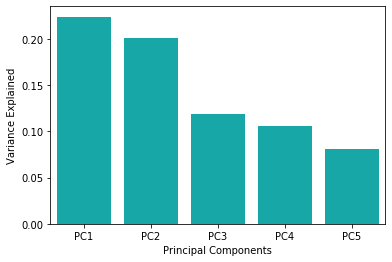

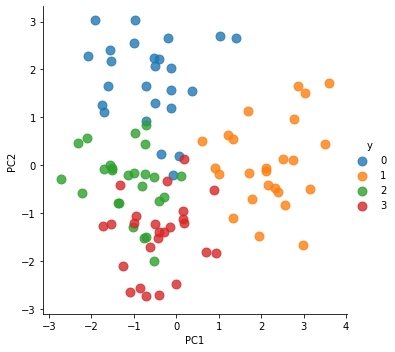

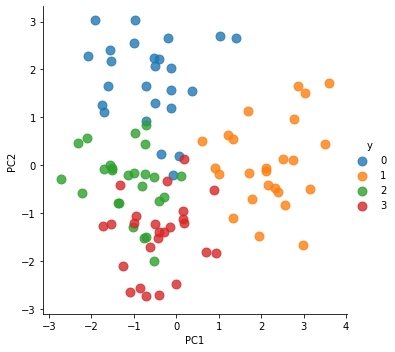

In [85]:
do_KmeansPCA()

In [76]:
model.forward(x_path=x_path)

(tensor([[1.0000, 0.0000, 1.0000, 0.9998]], grad_fn=<SigmoidBackward>),
 tensor([[0., 0., 0., 0.]], grad_fn=<CumprodBackward>),
 tensor([[2]]),
 None,
 None)

In [69]:
import ..models

SyntaxError: invalid syntax (<ipython-input-69-c543913fa78f>, line 1)

In [63]:
x_path = torch.randint(10, size=(500, 1024)).type(torch.FloatTensor)

In [65]:
self = MM_CoAttn_Transformer_Surv(omic_sizes=sig_sizes)

NameError: name 'MultiheadAttention' is not defined

In [52]:
self = MM_CoAttn_Surv(sig_sizes=sig_sizes)
x_path = torch.randint(10, size=(500, 1024)).type(torch.FloatTensor)
sig_feats = [torch.randint(10, size=(size,)).type(torch.FloatTensor) for size in sig_sizes]

x_path = self.attention_net(x_path).unsqueeze(1)
x_omic = torch.stack([self.sig_networks[idx].forward(sig_feat) for idx, sig_feat in enumerate(sig_feats)]).unsqueeze(1)

out, attention_weights = self.coattn(x_omic, x_path, x_path)
out = self.transformer(out)
out = self.conv(out.squeeze(1).T.unsqueeze(0))
#out = self.classifier(out.squeeze(0).squeeze(1))

NameError: name 'sig_size' is not defined

In [471]:
out.shape

torch.Size([1, 256, 1])

In [472]:
x_omic

tensor([[[ 0.5998,  1.9873, -1.1435,  ..., -0.0048,  0.2963,  1.1112]],

        [[-0.4201, -0.1456,  0.2057,  ..., -0.2175,  0.4188,  0.4702]],

        [[ 1.0294,  3.1634,  0.4595,  ...,  1.2059,  0.5845,  1.4114]],

        [[-1.1435, -1.1435, -1.1435,  ...,  0.1951, -0.4378,  0.2051]],

        [[ 0.9948,  1.1596,  2.1419,  ..., -0.1225,  1.3597, -0.3037]],

        [[ 0.4019, -1.1435, -0.1522,  ..., -0.2058,  0.0351, -1.1435]]],
       grad_fn=<UnsqueezeBackward0>)

In [474]:
self = MM_CoAttn_Surv(sig_sizes=sig_sizes)
x_path = torch.randint(10, size=(500, 1024)).type(torch.FloatTensor)
sig_feats = [torch.randint(10, size=(size,)).type(torch.FloatTensor) for size in sig_sizes]

x_path = self.attention_net(x_path).unsqueeze(1)
x_omic = torch.stack([self.sig_networks[idx].forward(sig_feat) for idx, sig_feat in enumerate(sig_feats)]).unsqueeze(1)
out, attention_weights = self.coattn(x_omic, x_path, x_path)

out = self.transformer(out)


In [491]:
torch.cat([self.sig_networks[idx].forward(sig_feat) for idx, sig_feat in enumerate(sig_feats)]).shape

torch.Size([1536])

In [484]:
torch.cat([out, out], axis=2).shape

torch.Size([6, 1, 512])

In [455]:
out.shape

torch.Size([6, 1, 256])

In [452]:
out.shape

torch.Size([6, 1, 256])

In [423]:
attention_weights.shape

torch.Size([1, 8, 6, 500])

In [415]:
attention_weights_0

tensor([[[0.0018, 0.0020, 0.0012,  ..., 0.0016, 0.0025, 0.0031],
         [0.0026, 0.0015, 0.0016,  ..., 0.0021, 0.0021, 0.0016],
         [0.0019, 0.0014, 0.0011,  ..., 0.0020, 0.0013, 0.0025],
         [0.0016, 0.0013, 0.0023,  ..., 0.0009, 0.0015, 0.0027],
         [0.0015, 0.0013, 0.0023,  ..., 0.0026, 0.0019, 0.0026],
         [0.0013, 0.0019, 0.0025,  ..., 0.0022, 0.0020, 0.0021]]],
       grad_fn=<DivBackward0>)

In [416]:
softmax(attention_weights_1, dim=-1).sum(axis=1) / 8

tensor([[[0.0018, 0.0020, 0.0012,  ..., 0.0016, 0.0025, 0.0031],
         [0.0026, 0.0015, 0.0016,  ..., 0.0021, 0.0021, 0.0016],
         [0.0019, 0.0014, 0.0011,  ..., 0.0020, 0.0013, 0.0025],
         [0.0016, 0.0013, 0.0023,  ..., 0.0009, 0.0015, 0.0027],
         [0.0015, 0.0013, 0.0023,  ..., 0.0026, 0.0019, 0.0026],
         [0.0013, 0.0019, 0.0025,  ..., 0.0022, 0.0020, 0.0021]]],
       grad_fn=<DivBackward0>)

In [411]:
softmax(attention_weights_1, dim=-1).shape

torch.Size([1, 1, 6, 500])

In [339]:
attention_weights_0[0][0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [396]:
test = softmax(attention_weights_2, dim=-1)

In [402]:
attention_weights_0[0][0][:20]

tensor([0.0024, 0.0030, 0.0019, 0.0018, 0.0038, 0.0015, 0.0020, 0.0016, 0.0015,
        0.0019, 0.0015, 0.0035, 0.0026, 0.0017, 0.0014, 0.0013, 0.0023, 0.0020,
        0.0017, 0.0010], grad_fn=<SliceBackward>)

In [404]:
test[0][0][:20]

tensor([0.0028, 0.0033, 0.0019, 0.0013, 0.0042, 0.0016, 0.0024, 0.0018, 0.0019,
        0.0024, 0.0016, 0.0033, 0.0022, 0.0014, 0.0016, 0.0013, 0.0023, 0.0021,
        0.0013, 0.0013], grad_fn=<SliceBackward>)

In [366]:
torch.eq(attention_weights_0, test)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [320]:
attention_weights_1.shape

torch.Size([1, 8, 6, 500])

In [318]:
attention_weights_2.shape

torch.Size([1, 6, 500])

In [282]:
out = self.classifier(out.squeeze(0).squeeze(1))

In [284]:
out

tensor([ 0.2832,  0.1548, -0.0972, -0.2801], grad_fn=<AddBackward0>)

In [269]:
attention_weights[0]

tensor([[0.0018, 0.0019, 0.0019,  ..., 0.0019, 0.0022, 0.0018],
        [0.0020, 0.0020, 0.0021,  ..., 0.0021, 0.0020, 0.0020],
        [0.0019, 0.0022, 0.0021,  ..., 0.0019, 0.0019, 0.0020],
        [0.0021, 0.0022, 0.0019,  ..., 0.0018, 0.0020, 0.0021],
        [0.0019, 0.0019, 0.0020,  ..., 0.0020, 0.0018, 0.0019],
        [0.0021, 0.0021, 0.0019,  ..., 0.0019, 0.0021, 0.0021]],
       grad_fn=<SelectBackward>)

In [241]:
self.coattn(x_omic, x_path, x_path)

(tensor([[[-0.0504,  0.0757, -0.0366,  ..., -0.0275, -0.0294,  0.1300]],
 
         [[-0.0500,  0.0762, -0.0352,  ..., -0.0253, -0.0289,  0.1311]],
 
         [[-0.0497,  0.0772, -0.0321,  ..., -0.0246, -0.0288,  0.1301]],
 
         [[-0.0491,  0.0794, -0.0337,  ..., -0.0260, -0.0278,  0.1281]],
 
         [[-0.0483,  0.0781, -0.0343,  ..., -0.0246, -0.0301,  0.1321]],
 
         [[-0.0499,  0.0768, -0.0305,  ..., -0.0257, -0.0280,  0.1321]]],
        grad_fn=<AddBackward0>),
 tensor([[[0.0019, 0.0019, 0.0019,  ..., 0.0020, 0.0021, 0.0021],
          [0.0017, 0.0020, 0.0020,  ..., 0.0019, 0.0019, 0.0018],
          [0.0019, 0.0018, 0.0019,  ..., 0.0019, 0.0019, 0.0021],
          [0.0020, 0.0020, 0.0019,  ..., 0.0020, 0.0021, 0.0019],
          [0.0017, 0.0023, 0.0021,  ..., 0.0019, 0.0020, 0.0020],
          [0.0021, 0.0021, 0.0020,  ..., 0.0021, 0.0021, 0.0020]]],
        grad_fn=<DivBackward0>))

In [ ]:
h

In [208]:
sig_feats = [torch.randn(size) for size in sig_sizes]
x_omic = torch.stack([self.sig_networks[idx].forward(sig_feat) for idx, sig_feat in enumerate(sig_feats)])


In [206]:
x_omic.shape

torch.Size([6, 256])

In [166]:
sig1, sig2, sig3, sig4, sig5, sig6 = torch.randn()

NameError: name 'sig1' is not defined

In [158]:
src = torch.rand(6, 1, 256)
out = transformer(src)
out = out.squeeze(1).T.unsqueeze(0)

In [163]:
conv = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=4, stride=4)

In [164]:
out.shape

torch.Size([1, 256, 6])

In [165]:
conv(out).shape

torch.Size([1, 256, 1])

In [112]:
x.reshape(-1).shape

torch.Size([1536])

In [106]:
256 * 12

3072

In [88]:
net = Attn_Net_Gated()
wsi_feats = torch.randn(500, 1, 256)
sig_feats = torch.randn(6, 1, 256)

In [89]:
multihead_attn = nn.MultiheadAttention(embed_dim=256, num_heads=8)

In [90]:
out, coattn_weights = multihead_attn(sig_feats, wsi_feats, wsi_feats)

In [96]:
cotton = DenseCoAttn(dim1=256, dim2=256, num_attn=8, num_none=3, dropout=0.3b)

In [100]:
from math import sqrt
wsi_feats = torch.randn(1, 500, 256)
sig_feats = torch.randn(1, 6, 256)
_ = cotton(wsi_feats, sig_feats)

In [103]:
_[0].shape

torch.Size([1, 6, 256])

In [104]:
_[1].shape

torch.Size([1, 500, 256])

In [94]:

import torch
import torch.nn as nn
import torch.nn.functional as F


def qkv_attention(query, key, value, mask=None, dropout=None):
	d_k = query.size(-1)
	scores = torch.matmul(query, key.transpose(-2,-1)) / sqrt(d_k)
	if mask is not None:
		scores.data.masked_fill_(mask.eq(0), -65504.0)
	
	p_attn = F.softmax(scores, dim=-1)
	if dropout is not None:
		p_attn = dropout(p_attn)

	return torch.matmul(p_attn, value), p_attn


class DenseCoAttn(nn.Module):

	def __init__(self, dim1, dim2, num_attn, num_none, dropout, is_multi_head=False):
		super(DenseCoAttn, self).__init__()
		dim = min(dim1, dim2)
		self.linears = nn.ModuleList([nn.Linear(dim1, dim, bias=False),
									  nn.Linear(dim2, dim, bias=False)])
		self.nones = nn.ParameterList([nn.Parameter(nn.init.xavier_uniform_(torch.empty(num_none, dim1))),
									   nn.Parameter(nn.init.xavier_uniform_(torch.empty(num_none, dim2)))])
		self.d_k = dim // num_attn
		self.h = num_attn
		self.num_none = num_none
		self.is_multi_head = is_multi_head
		self.attn = None
		self.dropouts = nn.ModuleList([nn.Dropout(p=dropout) for _ in range(2)])

	def forward(self, value1, value2, mask1=None, mask2=None):
		batch = value1.size(0)
		dim1, dim2 = value1.size(-1), value2.size(-1)
		value1 = torch.cat([self.nones[0].unsqueeze(0).expand(batch, self.num_none, dim1), value1], dim=1)
		value2 = torch.cat([self.nones[1].unsqueeze(0).expand(batch, self.num_none, dim2), value2], dim=1)
		none_mask = value1.new_ones((batch, self.num_none))

		if mask1 is not None:
			mask1 = torch.cat([none_mask, mask1], dim=1)
			mask1 = mask1.unsqueeze(1).unsqueeze(2)
		if mask2 is not None:
			mask2 = torch.cat([none_mask, mask2], dim=1)
			mask2 = mask2.unsqueeze(1).unsqueeze(2)

		query1, query2 = [l(x).view(batch, -1, self.h, self.d_k).transpose(1, 2) 
			for l, x in zip(self.linears, (value1, value2))]

		if self.is_multi_head:
			weighted1, attn1 = qkv_attention(query2, query1, query1, mask=mask1, dropout=self.dropouts[0])
			weighted1 = weighted1.transpose(1, 2).contiguous()[:, self.num_none:, :]
			weighted2, attn2 = qkv_attention(query1, query2, query2, mask=mask2, dropout=self.dropouts[1])
			weighted2 = weighted2.transpose(1, 2).contiguous()[:, self.num_none:, :]
		else:
			weighted1, attn1 = qkv_attention(query2, query1, value1.unsqueeze(1), mask=mask1, 
				dropout=self.dropouts[0])
			weighted1 = weighted1.mean(dim=1)[:, self.num_none:, :]
			weighted2, attn2 = qkv_attention(query1, query2, value2.unsqueeze(1), mask=mask2, 
				dropout=self.dropouts[1])
			weighted2 = weighted2.mean(dim=1)[:, self.num_none:, :]
		self.attn = [attn1[:,:,self.num_none:,self.num_none:], attn2[:,:,self.num_none:,self.num_none:]]

		return weighted1, weighted2


In [417]:
from torch.nn.functional import *

def multi_head_attention_forward(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    embed_dim_to_check: int,
    num_heads: int,
    in_proj_weight: Tensor,
    in_proj_bias: Tensor,
    bias_k: Optional[Tensor],
    bias_v: Optional[Tensor],
    add_zero_attn: bool,
    dropout_p: float,
    out_proj_weight: Tensor,
    out_proj_bias: Tensor,
    training: bool = True,
    key_padding_mask: Optional[Tensor] = None,
    need_weights: bool = True,
    need_raw: bool = True,
    attn_mask: Optional[Tensor] = None,
    use_separate_proj_weight: bool = False,
    q_proj_weight: Optional[Tensor] = None,
    k_proj_weight: Optional[Tensor] = None,
    v_proj_weight: Optional[Tensor] = None,
    static_k: Optional[Tensor] = None,
    static_v: Optional[Tensor] = None,
) -> Tuple[Tensor, Optional[Tensor]]:
    r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        embed_dim_to_check: total dimension of the model.
        num_heads: parallel attention heads.
        in_proj_weight, in_proj_bias: input projection weight and bias.
        bias_k, bias_v: bias of the key and value sequences to be added at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        dropout_p: probability of an element to be zeroed.
        out_proj_weight, out_proj_bias: the output projection weight and bias.
        training: apply dropout if is ``True``.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
        use_separate_proj_weight: the function accept the proj. weights for query, key,
            and value in different forms. If false, in_proj_weight will be used, which is
            a combination of q_proj_weight, k_proj_weight, v_proj_weight.
        q_proj_weight, k_proj_weight, v_proj_weight, in_proj_bias: input projection weight and bias.
        static_k, static_v: static key and value used for attention operators.
    Shape:
        Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the zero positions
          will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensures that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - static_k: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        - static_v: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
    """
    tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v, out_proj_weight, out_proj_bias)
    if has_torch_function(tens_ops):
        return handle_torch_function(
            multi_head_attention_forward,
            tens_ops,
            query,
            key,
            value,
            embed_dim_to_check,
            num_heads,
            in_proj_weight,
            in_proj_bias,
            bias_k,
            bias_v,
            add_zero_attn,
            dropout_p,
            out_proj_weight,
            out_proj_bias,
            training=training,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            need_raw=need_raw,
            attn_mask=attn_mask,
            use_separate_proj_weight=use_separate_proj_weight,
            q_proj_weight=q_proj_weight,
            k_proj_weight=k_proj_weight,
            v_proj_weight=v_proj_weight,
            static_k=static_k,
            static_v=static_v,
        )
    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == embed_dim_to_check
    # allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

    head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
    scaling = float(head_dim) ** -0.5

    if not use_separate_proj_weight:
        if (query is key or torch.equal(query, key)) and (key is value or torch.equal(key, value)):
            # self-attention
            q, k, v = linear(query, in_proj_weight, in_proj_bias).chunk(3, dim=-1)

        elif key is value or torch.equal(key, value):
            # encoder-decoder attention
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = linear(query, _w, _b)

            if key is None:
                assert value is None
                k = None
                v = None
            else:

                # This is inline in_proj function with in_proj_weight and in_proj_bias
                _b = in_proj_bias
                _start = embed_dim
                _end = None
                _w = in_proj_weight[_start:, :]
                if _b is not None:
                    _b = _b[_start:]
                k, v = linear(key, _w, _b).chunk(2, dim=-1)

        else:
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = linear(query, _w, _b)

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim
            _end = embed_dim * 2
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            k = linear(key, _w, _b)

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim * 2
            _end = None
            _w = in_proj_weight[_start:, :]
            if _b is not None:
                _b = _b[_start:]
            v = linear(value, _w, _b)
    else:
        q_proj_weight_non_opt = torch.jit._unwrap_optional(q_proj_weight)
        len1, len2 = q_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == query.size(-1)

        k_proj_weight_non_opt = torch.jit._unwrap_optional(k_proj_weight)
        len1, len2 = k_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == key.size(-1)

        v_proj_weight_non_opt = torch.jit._unwrap_optional(v_proj_weight)
        len1, len2 = v_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == value.size(-1)

        if in_proj_bias is not None:
            q = linear(query, q_proj_weight_non_opt, in_proj_bias[0:embed_dim])
            k = linear(key, k_proj_weight_non_opt, in_proj_bias[embed_dim : (embed_dim * 2)])
            v = linear(value, v_proj_weight_non_opt, in_proj_bias[(embed_dim * 2) :])
        else:
            q = linear(query, q_proj_weight_non_opt, in_proj_bias)
            k = linear(key, k_proj_weight_non_opt, in_proj_bias)
            v = linear(value, v_proj_weight_non_opt, in_proj_bias)
    q = q * scaling

    if attn_mask is not None:
        assert (
            attn_mask.dtype == torch.float32
            or attn_mask.dtype == torch.float64
            or attn_mask.dtype == torch.float16
            or attn_mask.dtype == torch.uint8
            or attn_mask.dtype == torch.bool
        ), "Only float, byte, and bool types are supported for attn_mask, not {}".format(attn_mask.dtype)
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError("The size of the 2D attn_mask is not correct.")
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]:
                raise RuntimeError("The size of the 3D attn_mask is not correct.")
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
        # attn_mask's dim is 3 now.

    # convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn(
            "Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead."
        )
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))
        else:
            assert static_k is None, "bias cannot be added to static key."
            assert static_v is None, "bias cannot be added to static value."
    else:
        assert bias_k is None
        assert bias_v is None

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

    if static_k is not None:
        assert static_k.size(0) == bsz * num_heads
        assert static_k.size(2) == head_dim
        k = static_k

    if static_v is not None:
        assert static_v.size(0) == bsz * num_heads
        assert static_v.size(2) == head_dim
        v = static_v

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.size(0) == bsz
        assert key_padding_mask.size(1) == src_len

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    assert list(attn_output_weights.size()) == [bsz * num_heads, tgt_len, src_len]

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float("-inf"))
        else:
            attn_output_weights += attn_mask

    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float("-inf"),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)
    
    attn_output_weights_raw = attn_output_weights
    attn_output_weights = softmax(attn_output_weights, dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)
    
    if need_weights:
        if need_raw:
            
            attn_output_weights_raw = attn_output_weights_raw.view(bsz, num_heads, tgt_len, src_len)
            return attn_output,attn_output_weights_raw
            
            #attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
            #return attn_output, attn_output_weights.sum(dim=1) / num_heads, attn_output_weights_raw, attn_output_weights_raw.sum(dim=1) / num_heads
        else:
            # average attention weights over heads
            attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
            return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None


In [418]:
import torch
from torch import Tensor
from torch.nn.modules.linear import _LinearWithBias
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
from torch.nn.init import xavier_normal_
from torch.nn.parameter import Parameter
from torch.nn import Module

class MultiheadAttention(Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces.
    See reference: Attention Is All You Need

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.

        Note: if kdim and vdim are None, they will be set to embed_dim such that
        query, key, and value have the same number of features.

    Examples::

        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = Parameter(torch.Tensor(embed_dim, embed_dim))
            self.k_proj_weight = Parameter(torch.Tensor(embed_dim, self.kdim))
            self.v_proj_weight = Parameter(torch.Tensor(embed_dim, self.vdim))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty(3 * embed_dim, embed_dim))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = _LinearWithBias(embed_dim, embed_dim)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty(1, 1, embed_dim))
            self.bias_v = Parameter(torch.empty(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, need_raw=True, attn_mask=None):
        # type: (Tensor, Tensor, Tensor, Optional[Tensor], bool, Optional[Tensor]) -> Tuple[Tensor, Optional[Tensor]]
        r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored. When given
            a byte mask and a value is non-zero, the corresponding value on the attention
            layer will be ignored
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the position
          with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.

        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        """
        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights, need_raw=need_raw,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight)
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights, need_raw=need_raw,
                attn_mask=attn_mask)

In [104]:
import math

import torch
from torch import nn

############
# Omic Model
############
def init_max_weights(module):
    for m in module.modules():
        if type(m) == nn.Linear:
            stdv = 1. / math.sqrt(m.weight.size(1))
            m.weight.data.normal_(0, stdv)
            m.bias.data.zero_()

def SNN_Block(dim1, dim2, dropout=0.25):
    return nn.Sequential(
            nn.Linear(dim1, dim2),
            nn.ELU(),
            nn.AlphaDropout(p=dropout, inplace=False))

class MaxNet(nn.Module):
    def __init__(self, input_dim: int, meta_dim: int=0, model_size_omic: str='small', n_classes: int=4):
        super(MaxNet, self).__init__()
        self.meta_dim = meta_dim
        self.n_classes = n_classes
        self.size_dict_omic = {'small': [256, 256, 256, 256], 'big': [1024, 1024, 1024, 256]}
        
        ### Constructing Genomic SNN
        hidden = self.size_dict_omic[model_size_omic]
        fc_omic = [SNN_Block(dim1=input_dim, dim2=hidden[0])]
        for i, _ in enumerate(hidden[1:]):
            fc_omic.append(SNN_Block(dim1=hidden[i], dim2=hidden[i+1], dropout=0.25))
        self.fc_omic = nn.Sequential(*fc_omic)
        self.classifier = nn.Linear(hidden[-1]+self.meta_dim, n_classes)
        init_max_weights(self)

    def forward(self, **kwargs):
        x = kwargs['x_omic']
        meta = kwargs['meta']
        features = self.fc_omic(x)

        if self.meta_dim: 
            axis_dim = 1 if len(meta.shape) > 1 else 0
            features = torch.cat((features, meta), axis_dim)

        logits = self.classifier(features).unsqueeze(0)
        Y_hat = torch.topk(logits, 1, dim=1)[1]
        hazards = torch.sigmoid(logits)
        S = torch.cumprod(1 - hazards, dim=1)
        return hazards, S, Y_hat, None, None

    def relocate(self):
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

            if torch.cuda.device_count() > 1:
                device_ids = list(range(torch.cuda.device_count()))
                self.fc_omic = nn.DataParallel(self.fc_omic, device_ids=device_ids).to('cuda:0')
            else:
                self.fc_omic = self.fc_omic.to(device)


            self.classifier = self.classifier.to(device)

ModuleNotFoundError: No module named 'torch'

In [88]:
genomic_features[series_intersecdef series_intersection(s1, s2):
    return pd.Series(list(set(s1) & set(s2)))
tion(sig, genomic_features.columns)]

,CXCL14_rnaseq,FGF1_rnaseq,IFNA8_cnv,ADM_rnaseq,LTBP2_rnaseq,CCL28_rnaseq,IFNA7_rnaseq,GH2_rnaseq,AIMP1_rnaseq,DEFB1_rnaseq,...,NPPB_rnaseq,CCL27_rnaseq,FASLG_rnaseq,FGF20_cnv,FAM3C_rnaseq,IL18_rnaseq,GDF10_rnaseq,MYDGF_rnaseq,IL10_rnaseq,IFNW1_rnaseq
0,-0.1170,-0.2221,1,-0.5126,-0.3289,-0.7331,-0.1244,-0.1693,0.5942,-0.4707,...,-0.2276,1.2033,0.9826,-1,-0.6161,-0.5643,-0.2165,-0.2836,0.9991,-0.3899
1,-0.2330,-0.4343,-1,-0.2381,-0.4799,-0.0520,-0.1244,-0.1693,1.1854,-0.4820,...,-0.2276,-0.2946,-0.5443,-1,-0.3499,-0.7958,-0.3140,-0.3359,-0.4865,-0.3899
2,-0.1384,-0.1597,-1,-0.1521,-0.3348,-0.5310,-0.1244,-0.1693,0.3889,-0.3607,...,3.4177,-0.2946,-0.5320,0,0.4581,-0.6179,-0.2107,0.2751,-0.5108,1.0629
3,-0.1624,-0.3463,-1,0.0272,-0.7623,0.8196,-0.1244,-0.1693,-0.0416,0.1661,...,-0.2276,-0.1020,-0.4682,-1,-0.4391,-0.7275,-0.2876,-0.4696,-0.6248,-0.3899
4,-0.2346,-0.4090,-1,-0.2078,0.5702,-0.4219,-0.1244,0.5257,-0.9790,0.3938,...,-0.2276,-0.1035,-0.4688,-1,1.2596,-0.5807,0.4108,0.1801,-0.6086,-0.3899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,-0.2417,10.1423,-1,-0.5456,0.8742,-0.1822,-0.1244,-0.1693,-1.2395,-0.5125,...,-0.2276,-0.2946,0.0777,0,-0.8242,-0.6727,0.1938,0.9210,0.4479,-0.3899
369,-0.2412,1.3253,1,-0.5680,1.0719,-0.1707,-0.1244,-0.1693,-1.6694,-0.4528,...,0.5679,-0.2661,1.0215,-2,-0.5327,0.3335,-0.1730,0.0147,0.6012,2.2526
370,-0.2396,0.0435,0,-0.3610,3.1965,1.3670,-0.1244,-0.1693,0.4439,-0.5099,...,-0.2276,-0.2289,0.0521,-1,1.0317,-0.1473,-0.1517,0.9384,-0.3165,0.6239
371,-0.2393,-0.4475,0,0.4772,2.9612,-0.7799,-0.1244,-0.1693,0.5778,1.7607,...,-0.2276,9.4098,-0.5443,0,0.2992,-0.5451,-0.2456,0.8898,-0.5781,-0.3899


In [84]:
def series_intersection(s1, s2):
    return pd.Series(list(set(s1) & set(s2)))


In [68]:
genomic_features

,NDUFS5_cnv,MACF1_cnv,RNA5SP44_cnv,KIAA0754_cnv,BMP8A_cnv,PABPC4_cnv,SNORA55_cnv,HEYL_cnv,HPCAL4_cnv,NT5C1A_cnv,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-0.8388,4.1375,3.9664,1.8437,-0.3959,-0.2561,-0.2866,1.8770,-0.3179,-0.3633
1,2,2,2,2,2,2,2,2,2,2,...,-0.1083,0.3393,0.2769,1.7320,-0.0975,2.6955,-0.6741,1.0323,1.2766,-0.3982
2,0,0,0,0,0,0,0,0,0,0,...,-0.4155,1.6846,0.7711,-0.3061,-0.5016,2.8548,-0.6171,-0.8608,-0.0486,-0.3962
3,0,0,0,0,0,0,0,0,0,0,...,-0.8143,0.8344,1.5075,3.6068,-0.5004,-0.0747,-0.2185,-0.4379,1.6913,1.7748
4,0,0,0,0,0,0,0,0,0,0,...,0.0983,-0.7908,-0.0053,-0.0643,-0.3706,0.3870,-0.5589,-0.5979,0.0047,-0.3548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2,2,2,2,2,2,2,2,2,2,...,-0.0291,-0.1058,-0.6721,0.2802,1.9504,-0.8784,0.9506,0.0607,1.1883,-0.3521
369,0,0,0,0,0,0,0,0,0,0,...,0.0497,0.3673,-0.2208,0.3034,3.2580,-0.2089,1.6053,-0.8746,-0.4491,-0.3450
370,1,1,1,1,1,1,1,1,1,1,...,0.3822,-0.7003,-0.7661,-1.7035,-0.5423,-0.3488,1.3713,-0.4365,2.3456,-0.3866
371,0,0,0,0,0,0,0,0,0,0,...,-0.6853,-1.0240,-1.2890,-1.5666,-0.1270,-1.4662,0.3981,-0.5976,-1.3822,-0.4157


In [11]:
if 'case_id' not in slide_data:
    slide_data.index = slide_data.index.str[:12]
    slide_data['case_id'] = slide_data.index
    slide_data = slide_data.reset_index(drop=True)

In [14]:
new_cols = list(slide_data.columns[-2:]) + list(slide_data.columns[:-2])
slide_data = slide_data[new_cols]

In [15]:
slide_data

,ZZZ3_rnaseq,TPTEP1_rnaseq,slide_id,site,is_female,oncotree_code,age,survival_months,censorship,train,...,ZW10_rnaseq,ZWILCH_rnaseq,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq
case_id,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KO,-0.3179,-0.3633,TCGA-2F-A9KO-01Z-00-DX1.195576CF-B739-4BD9-B15...,2F,0,BLCA,63,24.11,0,1.0,...,-0.7172,0.7409,-0.8388,4.1375,3.9664,1.8437,-0.3959,-0.2561,-0.2866,1.8770
TCGA-2F-A9KP,1.2766,-0.3982,TCGA-2F-A9KP-01Z-00-DX1.3CDF534E-958F-4467-AA7...,2F,0,BLCA,66,11.96,0,1.0,...,0.6373,0.8559,-0.1083,0.3393,0.2769,1.7320,-0.0975,2.6955,-0.6741,1.0323
TCGA-2F-A9KP,1.2766,-0.3982,TCGA-2F-A9KP-01Z-00-DX2.718C82A3-252B-498E-BFB...,2F,0,BLCA,66,11.96,0,1.0,...,0.6373,0.8559,-0.1083,0.3393,0.2769,1.7320,-0.0975,2.6955,-0.6741,1.0323
TCGA-2F-A9KQ,-0.0486,-0.3962,TCGA-2F-A9KQ-01Z-00-DX1.1C8CB2DD-5CC6-4E99-A0F...,2F,0,BLCA,69,94.81,1,1.0,...,-0.5676,-0.0621,-0.4155,1.6846,0.7711,-0.3061,-0.5016,2.8548,-0.6171,-0.8608
TCGA-2F-A9KR,1.6913,1.7748,TCGA-2F-A9KR-01Z-00-DX1.D6A4BD2D-18F3-4FA6-827...,2F,1,BLCA,59,104.57,0,1.0,...,-1.3825,0.3550,-0.8143,0.8344,1.5075,3.6068,-0.5004,-0.0747,-0.2185,-0.4379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZF-AA54,1.1883,-0.3521,TCGA-ZF-AA54-01Z-00-DX1.9118BB51-333A-4257-A79...,ZF,0,BLCA,71,19.38,0,1.0,...,-0.0898,2.1092,-0.0291,-0.1058,-0.6721,0.2802,1.9504,-0.8784,0.9506,0.0607
TCGA-ZF-AA58,-0.4491,-0.3450,TCGA-ZF-AA58-01Z-00-DX1.85C3611E-11FA-4AAE-B88...,ZF,1,BLCA,61,54.17,1,1.0,...,-0.2075,-0.0617,0.0497,0.3673,-0.2208,0.3034,3.2580,-0.2089,1.6053,-0.8746
TCGA-ZF-AA5H,2.3456,-0.3866,TCGA-ZF-AA5H-01Z-00-DX1.2B5DF00E-E0FD-4C58-A82...,ZF,1,BLCA,60,29.47,1,1.0,...,-1.4118,-0.1236,0.3822,-0.7003,-0.7661,-1.7035,-0.5423,-0.3488,1.3713,-0.4365
